Kaggle Competition 

In [1]:
import json
import os
import logging

from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, GroupKFold
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance,PartialDependenceDisplay
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
import seaborn as sns
import redshift_connector
from dotenv import load_dotenv
import os

np.random.seed(1)
logging.basicConfig(level=logging.INFO)

In [66]:
house_price_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')


In [67]:
df = house_price_data.copy()

In [6]:
print("data shape:", house_price_data.shape)

data shape: (1460, 81)


In [7]:
print("data overview:", house_price_data.describe())
#lots of numerical features that aren't actually numeric | watch out here with EDA.  

data overview:                 Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207  

array([[<Axes: title={'center': 'SalePrice'}>]], dtype=object)

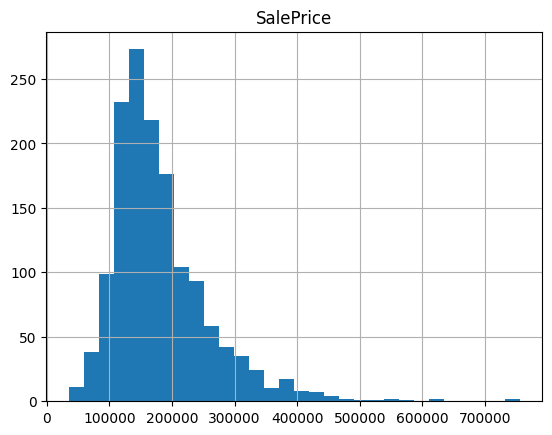

In [8]:
house_price_data.hist(column='SalePrice', bins=30)
#needs a log transformation given current distribution of target variable.

##Exploratory Analysis

### MSSubClass EDA

#MSSubClass: Identifies the type of dwelling involved in the sale.	
"""
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

       """


In [16]:
# Mapping MSSubClass codes to definitions
ms_subclass_map = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
    150: "1-1/2 STORY PUD - ALL AGES",
    160: "2-STORY PUD - 1946 & NEWER",
    180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
    190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"
}

house_price_data['MSSubClass_def'] = house_price_data['MSSubClass'].map(ms_subclass_map)
house_price_data[['MSSubClass', 'MSSubClass_def']].head()

,MSSubClass,MSSubClass_def
0,60,2-STORY 1946 & NEWER
1,20,1-STORY 1946 & NEWER ALL STYLES
2,60,2-STORY 1946 & NEWER
3,70,2-STORY 1945 & OLDER
4,60,2-STORY 1946 & NEWER


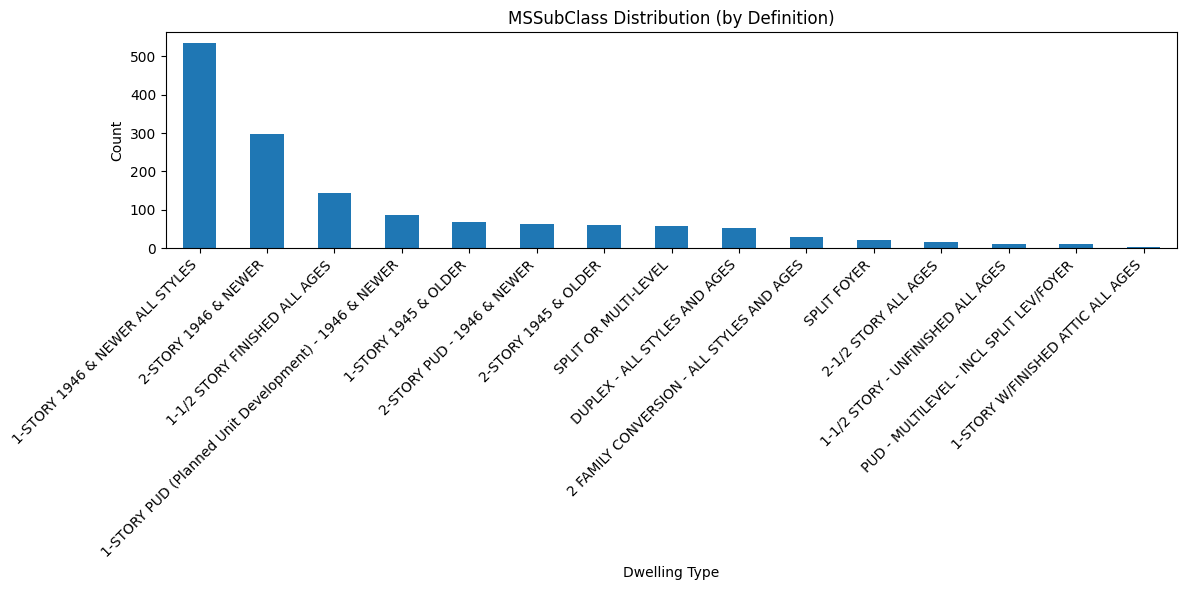

In [17]:
# Visualize MSSubClass counts with definitions
plt.figure(figsize=(12,6))
house_price_data['MSSubClass_def'].value_counts().plot(kind='bar')
plt.title('MSSubClass Distribution (by Definition)')
plt.ylabel('Count')
plt.xlabel('Dwelling Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

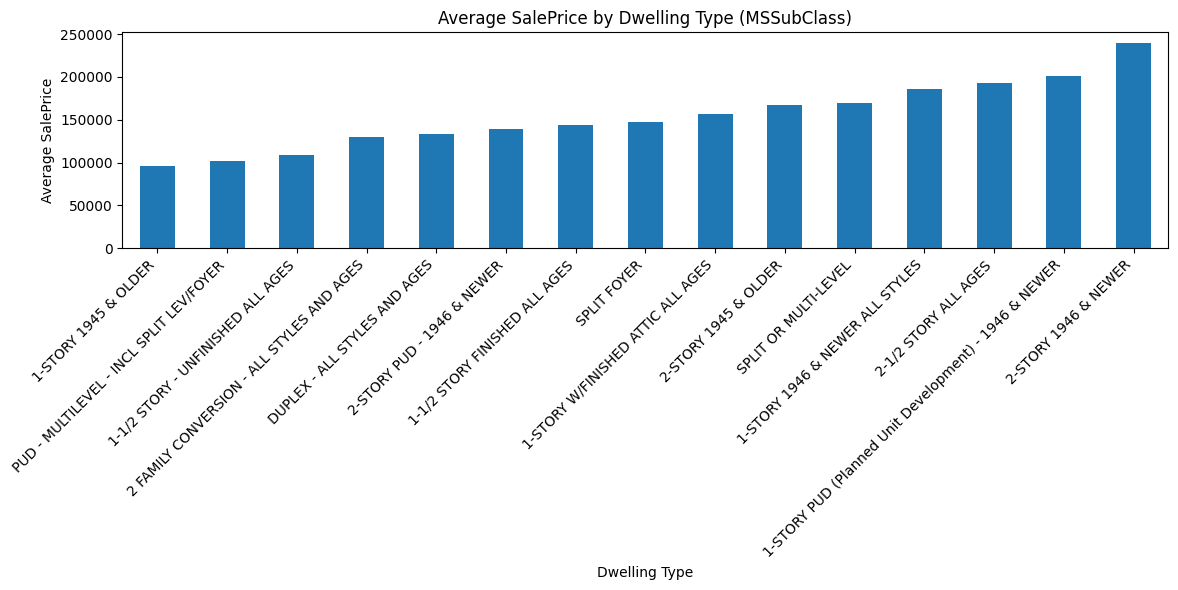

In [18]:
# Explore average SalePrice by MSSubClass definition
plt.figure(figsize=(12,6))
avg_price = house_price_data.groupby('MSSubClass_def')['SalePrice'].mean().sort_values()
avg_price.plot(kind='bar')
plt.title('Average SalePrice by Dwelling Type (MSSubClass)')
plt.ylabel('Average SalePrice')
plt.xlabel('Dwelling Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Story Group & Age Group from MSSubClass
Creating two new features:
- `StoryGroup`: Groups homes by number of stories (1, 1.5, 2, Split/Multi, Duplex, PUD, etc.)
- `AgeGroup`: Groups homes by age (Newer vs Older) based on MSSubClass definition.
This will help us analyze broader trends and improve model interpretability.

In [19]:
def get_story_group(subclass):
    if subclass in [20, 30, 40, 120]:
        return '1 Story'
    elif subclass in [45, 50, 150]:
        return '1.5 Story'
    elif subclass in [60, 70, 160]:
        return '2 Story'
    elif subclass in [75]:
        return '2.5 Story'
    elif subclass in [80, 85, 180]:
        return 'Split/Multi-Level'
    elif subclass in [90, 190]:
        return 'Duplex/Conversion'
    else:
        return 'Other'

def get_age_group(subclass):
    if subclass in [20, 60, 120, 160]:
        return 'Newer'
    elif subclass in [30, 70]:
        return 'Older'
    else:
        return 'All Ages/Other'

house_price_data['StoryGroup'] = house_price_data['MSSubClass'].apply(get_story_group)
house_price_data['AgeGroup'] = house_price_data['MSSubClass'].apply(get_age_group)
house_price_data[['MSSubClass', 'MSSubClass_def', 'StoryGroup', 'AgeGroup']].head()

,MSSubClass,MSSubClass_def,StoryGroup,AgeGroup
0,60,2-STORY 1946 & NEWER,2 Story,Newer
1,20,1-STORY 1946 & NEWER ALL STYLES,1 Story,Newer
2,60,2-STORY 1946 & NEWER,2 Story,Newer
3,70,2-STORY 1945 & OLDER,2 Story,Older
4,60,2-STORY 1946 & NEWER,2 Story,Newer


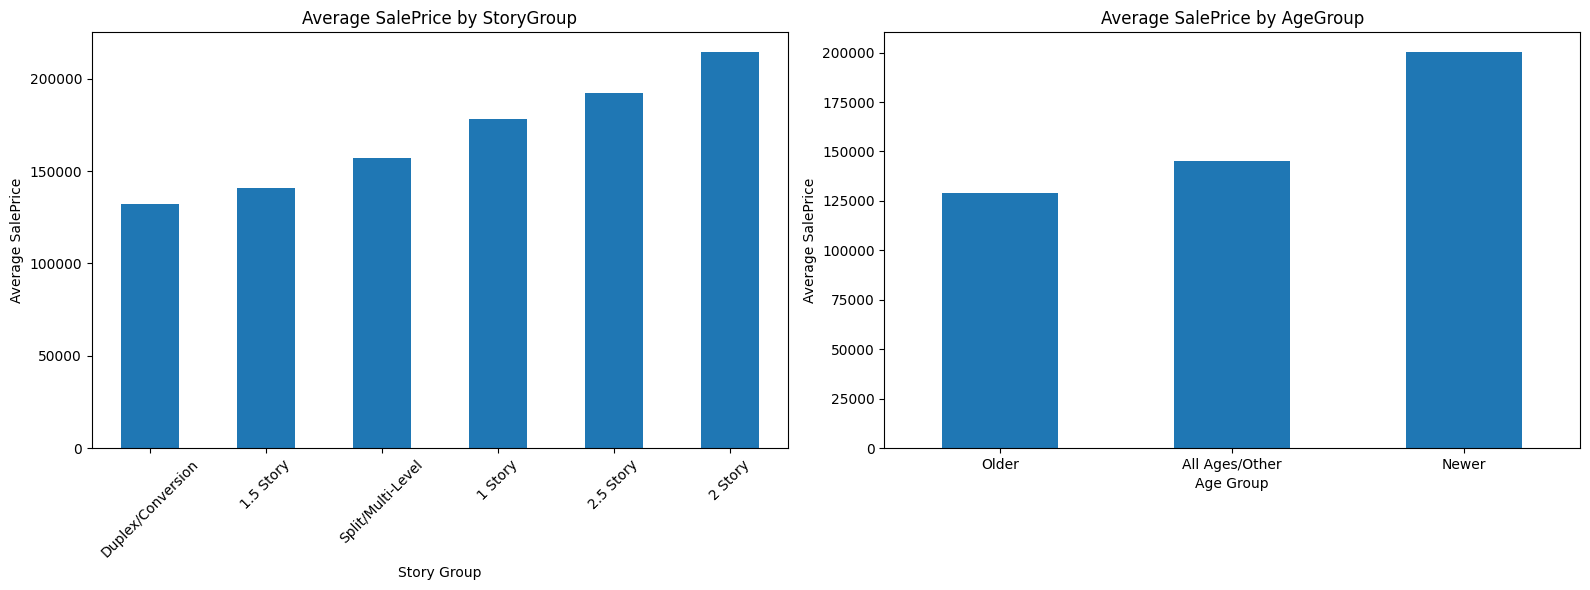

In [20]:
# Visualize average SalePrice by StoryGroup and AgeGroup
fig, axes = plt.subplots(1, 2, figsize=(16,6))

house_price_data.groupby('StoryGroup')['SalePrice'].mean().sort_values().plot(kind='bar', ax=axes[0])
axes[0].set_title('Average SalePrice by StoryGroup')
axes[0].set_ylabel('Average SalePrice')
axes[0].set_xlabel('Story Group')
axes[0].tick_params(axis='x', rotation=45)

house_price_data.groupby('AgeGroup')['SalePrice'].mean().sort_values().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average SalePrice by AgeGroup')
axes[1].set_ylabel('Average SalePrice')
axes[1].set_xlabel('Age Group')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### MSZoning EDA

MSZoning: Identifies the general zoning classification of the sale.
- A: Agriculture
- C: Commercial
- FV: Floating Village Residential
- I: Industrial
- RH: Residential High Density
- RL: Residential Low Density
- RP: Residential Low Density Park
- RM: Residential Medium Density

Let's map the codes, visualize their distribution, and analyze SalePrice by zoning.

In [ ]:
house_price_data['MSZoning'].value_counts()
#no properties listed as Agriculture or Industrial or Residential Low Density Park

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [24]:
# Mapping MSZoning codes to definitions
mszoning_map = {
    'A': 'Agriculture',
    'C (all)': 'Commercial',
    'FV': 'Floating Village Residential',
    'I': 'Industrial',
    'RH': 'Residential High Density',
    'RL': 'Residential Low Density',
    'RP': 'Residential Low Density Park',
    'RM': 'Residential Medium Density'
}

house_price_data['MSZoning_def'] = house_price_data['MSZoning'].map(mszoning_map)
house_price_data[['MSZoning', 'MSZoning_def']].head()

,MSZoning,MSZoning_def
0,RL,Residential Low Density
1,RL,Residential Low Density
2,RL,Residential Low Density
3,RL,Residential Low Density
4,RL,Residential Low Density


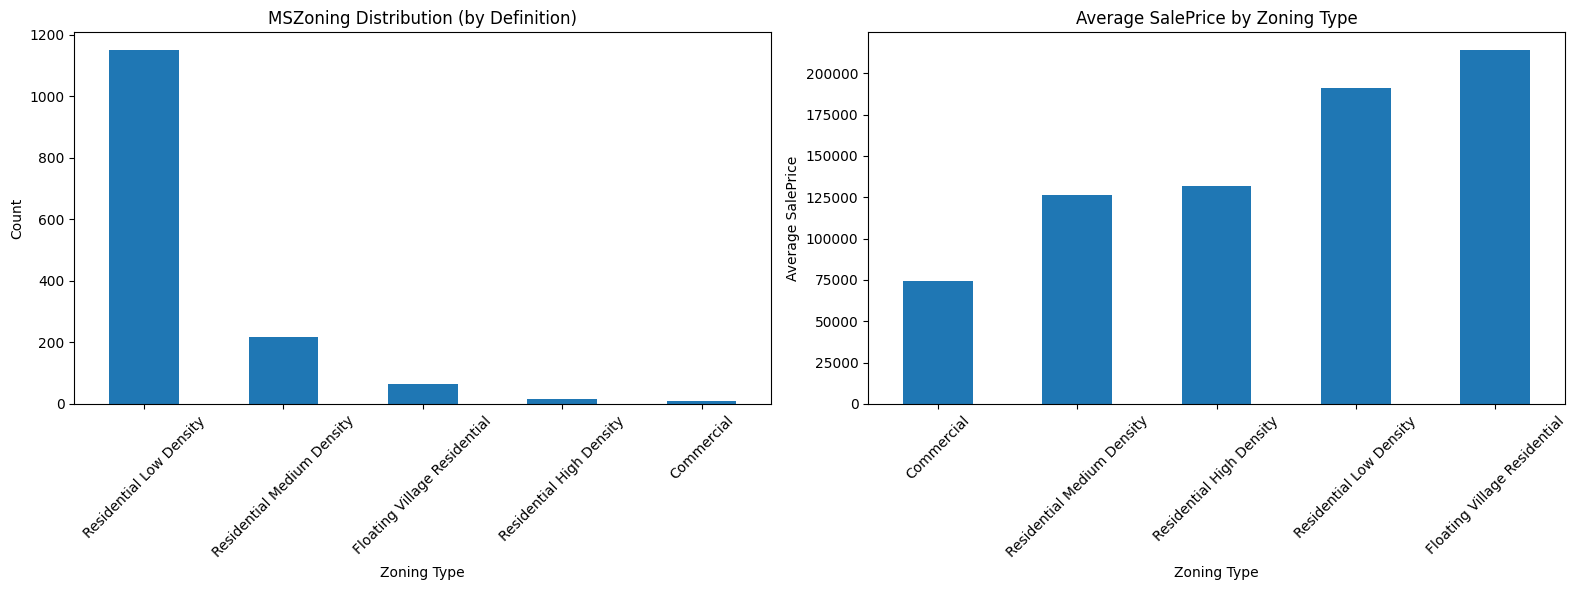

In [25]:
# Visualize MSZoning counts and average SalePrice by zoning definition
fig, axes = plt.subplots(1, 2, figsize=(16,6))

house_price_data['MSZoning_def'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('MSZoning Distribution (by Definition)')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Zoning Type')
axes[0].tick_params(axis='x', rotation=45)

house_price_data.groupby('MSZoning_def')['SalePrice'].mean().sort_values().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average SalePrice by Zoning Type')
axes[1].set_ylabel('Average SalePrice')
axes[1].set_xlabel('Zoning Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### LotFrontage: Linear feet of street connected to property


array([[<Axes: title={'center': 'LotFrontage'}>]], dtype=object)

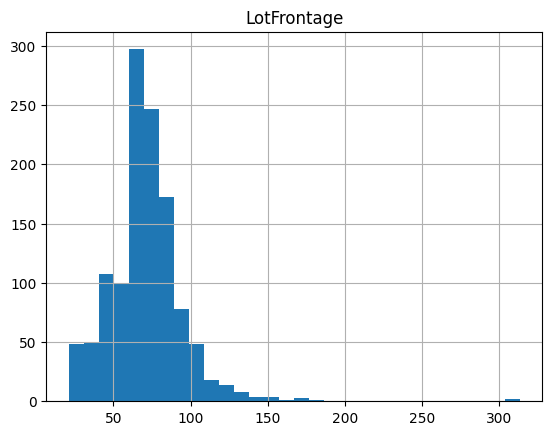

In [36]:
house_price_data[['LotFrontage']].hist(bins=30)

#potential outlier here? 

In [48]:
LotFrontage_Bins = range(0, 350, 25)
house_price_data['LotFrontage_Binned'] = pd.cut(house_price_data['LotFrontage'], bins=LotFrontage_Bins) 

house_price_data['LotFrontage_Binned'].value_counts()


LotFrontage_Binned
(50, 75]      581
(75, 100]     331
(25, 50]      163
(100, 125]     60
(0, 25]        42
(125, 150]     15
(150, 175]      6
(300, 325]      2
(175, 200]      1
(200, 225]      0
(225, 250]      0
(250, 275]      0
(275, 300]      0
Name: count, dtype: int64

/var/folders/7h/j94zr2xs6d149g6s96670f9c0000gn/T/ipykernel_5920/2425396485.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  house_price_data.groupby('LotArea_Binned')['SalePrice'].mean().plot(kind='bar')


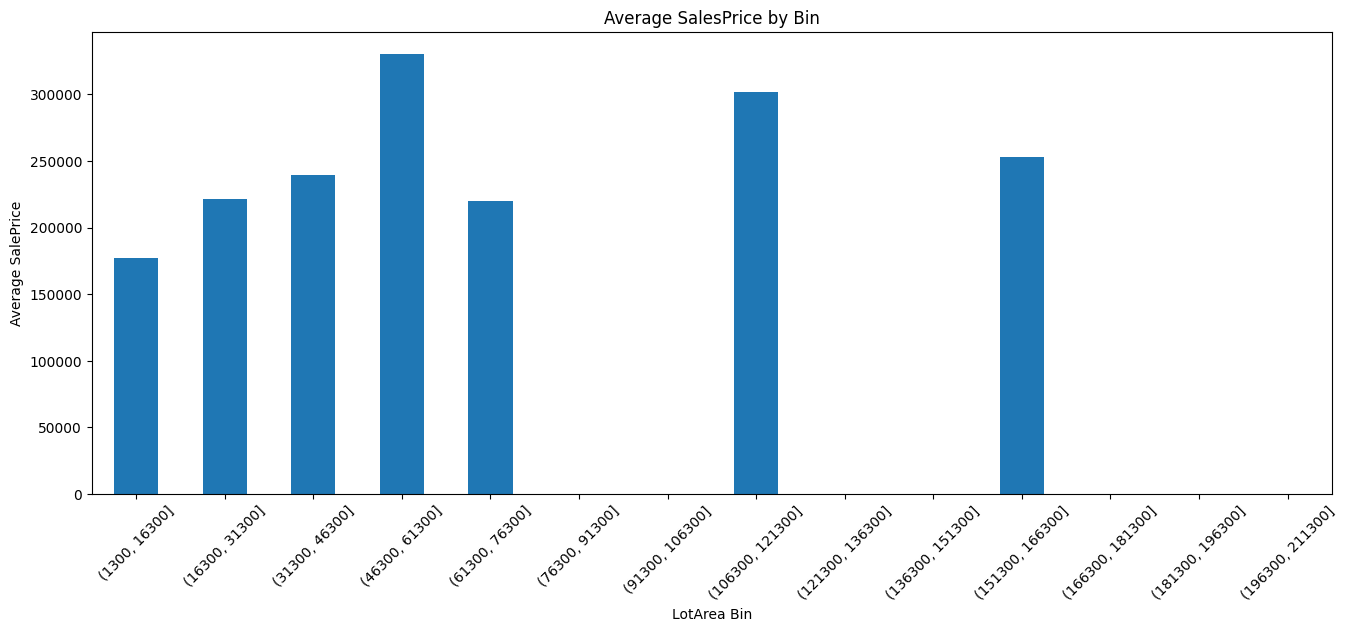

In [ ]:
#average SalesPrice in each bin

fig, axes = plt.subplots(1, 1, figsize=(16,6))
house_price_data.groupby('LotArea_Binned')['SalePrice'].mean().plot(kind='bar')
axes.set_title('Average SalesPrice by Bin')
axes.set_ylabel('Average SalePrice')
axes.set_xlabel('LotArea Bin')
axes.tick_params(axis='x', rotation=45)

plt.show()

#### LotArea: Lot size in square feet

array([[<Axes: title={'center': 'LotArea'}>]], dtype=object)

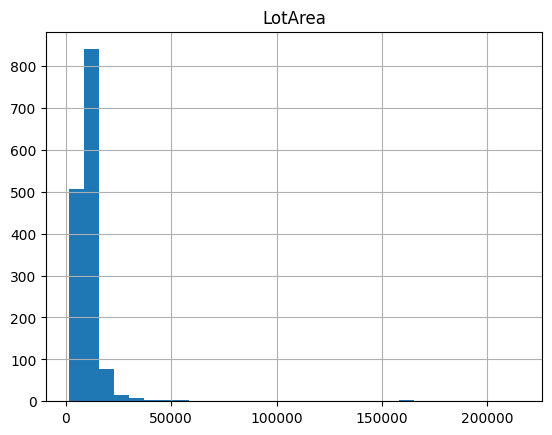

In [55]:
house_price_data[['LotArea']].hist(bins=30)

In [59]:
LotArea_Bins = range(house_price_data['LotArea'].min(), house_price_data['LotArea'].max(), 15000)
house_price_data['LotArea_Binned'] = pd.cut(house_price_data['LotArea'], bins=LotArea_Bins)

house_price_data['LotArea_Binned'].value_counts()


LotArea_Binned
(1300, 16300]       1366
(16300, 31300]        71
(31300, 46300]        10
(46300, 61300]         6
(61300, 76300]         2
(151300, 166300]       2
(106300, 121300]       1
(76300, 91300]         0
(91300, 106300]        0
(121300, 136300]       0
(136300, 151300]       0
(166300, 181300]       0
(181300, 196300]       0
(196300, 211300]       0
Name: count, dtype: int64

#### Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved

#### Create Pipeline

In [68]:
COLUMNS = df.columns.tolist()
int64_columns = df.select_dtypes(include=['int64']).columns.tolist()

In [88]:
ID_COLUMNS = ['Id', 'SalePrice']

NUMERIC_COLUMNS = [
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold']

CATEGORICAL_COLUMNS = [col for col in COLUMNS if col not in NUMERIC_COLUMNS and col not in ID_COLUMNS
]


In [89]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["SalePrice"]), df["SalePrice"], test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1168, 80)
y_train shape: (1168,)
X_test shape: (292, 80)
y_test shape: (292,)


In [90]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def get_preprocessing_pipeline():
    """
    Returns a pipeline that:
    - One-hot encodes categorical columns
    - Imputes missing values with median and scales numerical columns
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, NUMERIC_COLUMNS),
            ('cat', categorical_transformer, CATEGORICAL_COLUMNS)
        ],
        remainder='drop',
        verbose_feature_names_out=True
    )

    return preprocessor

# Example usage:
# pipeline = get_simple_preprocessing_pipeline()


In [91]:
def get_model_pipeline() -> Pipeline:
    """
    Create a model pipeline that includes preprocessing and an XGBoost regressor.

    This pipeline performs the following steps:
    1. Preprocess the data using the specified preprocessing pipeline.
    2. Train an XGBoost regressor on the preprocessed data.

    The XGBoost regressor is configured with the following parameters:
    - objective: 'reg:gamma' (specifies the gamma loss function)
    - booster: 'gbtree' (use tree boosting model, the default)
    - eval_metric: 'mae' (mean absolute error as the evaluation metric)
    - learning_rate: 0.05 (typical default learning rate)
    - n_estimators: 1000 (number of boosting rounds/trees)
    - max_depth: 5 (maximum depth of each tree)
    - colsample_bytree: 0.2 (column sampling per tree)
    - subsample: 0.8 (subsample ratio of the training instances)
    - random_state: 42 (random seed for reproducibility)
    - n_jobs: -1 (use all available cores for parallel processing)

    Returns:
    Pipeline
        A scikit-learn Pipeline object that performs the specified preprocessing steps and trains an XGBoost regressor.
    """
    preprocessing = get_preprocessing_pipeline()
    return make_pipeline(
        preprocessing,
        xgb.XGBRegressor(
            objective='reg:gamma',  # Specify gamma loss function
            booster='gbtree',       # Use tree boosting model (the default)
            eval_metric='mae',      # Mean Absolute Error as evaluation metric
            learning_rate=0.05,     # Typical default learning rate
            n_estimators=1000,      # Number of boosting rounds (trees)
            max_depth=5,            # Maximum depth of each tree
            colsample_bytree=0.2,   # Column sampling per tree
            subsample=0.8,          # Subsample ratio of the training instances
            random_state=42,        # Random seed for reproducibility
            n_jobs=-1,              # Use all available cores for parallel processing
        ),
    )

# Explanation of why XGBoost is being used instead of CatBoost:
# XGBoost is a powerful and widely-used gradient boosting library that provides efficient and scalable implementations of gradient boosting algorithms. It is known for its high performance and flexibility, making it suitable for a wide range of regression and classification tasks. XGBoost offers several advantages, including:
# - Speed and performance: XGBoost is optimized for speed and performance, making it faster than many other gradient boosting libraries.
# - Regularization: XGBoost includes built-in regularization techniques (L1 and L2) to prevent overfitting and improve model generalization.
# - Parallel processing: XGBoost supports parallel processing, allowing it to utilize multiple CPU cores for faster training.
# - Customization: XGBoost provides a wide range of hyperparameters that can be tuned to optimize model performance.

# While CatBoost is also a powerful gradient boosting library, XGBoost was chosen for this project due to its widespread adoption, extensive documentation, and proven track record in various machine learning competitions and real-world applications.

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'xgbregressor__max_depth': [3, 5, 7, 9],
    'xgbregressor__n_estimators': [50, 100, 200, 500],
}

In [92]:
from sklearn.model_selection import KFold
def train_and_gridsearch(X_train, y_train, param_grid, groups=None):
    """
    Train and evaluate the model using GroupKFold cross-validation and GridSearchCV.

    Steps:
    1. Creates a model pipeline with preprocessing and an XGBoost regressor.
    2. Sets up GroupKFold cross-validation (if groups provided) or standard KFold.
    3. Performs a grid search to find the best hyperparameters.
    4. Logs the best parameters and best score.

    Parameters:
    X_train : DataFrame
        The training input samples.
    y_train : array-like
        The true values for the training input samples.
    param_grid : dict
        The parameter grid for hyperparameter tuning.
    groups : array-like, optional
        Group labels for the samples used while splitting the dataset into train/test sets.

    Returns:
    best_model : estimator object
        The best model found by the grid search.
    """
    pipeline = get_model_pipeline()

    # Set up GroupKFold cross-validation if groups provided, else use KFold
    if groups is not None:
        cv = GroupKFold(n_splits=5)
    else:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Log-transform the target variable
    y_train_log, _ = boxcox(y_train)

    grid_search = GridSearchCV(
        pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train_log, groups=groups if groups is not None else None)

    logging.info(f"Best parameters: {grid_search.best_params_}")
    logging.info(f"Best score: {grid_search.best_score_}")

    best_model = grid_search.best_estimator_

    return best_model

In [94]:
best_model = train_and_gridsearch(X_train, y_train, param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


INFO:root:Best parameters: {'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 500}
INFO:root:Best score: -0.0021438695144792566
INFO:root:Best score: -0.0021438695144792566


In [96]:
def log_transform_target(y_train):
    """
    Log-transform the target variable and return the transformed values.

    Parameters:
    y_train : Series
        The true values for the training input samples.
    """
    # Log-transform the target variables
    return boxcox(y_train, lmbda=0.5)

In [97]:
def inverse_boxcox(y, lmbda):
    """
    Apply the inverse Box-Cox transformation.

    Parameters:
    y : array-like
        The transformed data to be inverted.
    lmbda : float
        The lambda parameter used in the original Box-Cox transformation.

    Returns:
    array-like
        The original data before the Box-Cox transformation.
    """
    # Apply the inverse Box-Cox transformation formula
    return ((y * lmbda) + 1) ** (1 / lmbda)

In [98]:
def plot_residuals(best_model, X_train, y_train, X_test, y_test):
    """
    Plot residuals of the model predictions for both training and test data.

    Parameters:
    best_model : estimator object
        The trained model used for making predictions.
    X_train : array-like
        The training input samples.
    y_train : array-like
        The true values for the training input samples.
    X_test : array-like
        The test input samples.
    y_test : array-like
        The true values for the test input samples.

    Returns:
    y_pred : array-like
        The predicted values for the test input samples.
    test_residuals : array-like
        The residuals for the test input samples.
    """
    train_pred = best_model.predict(X_train)
    train_pred = inverse_boxcox(train_pred, .5)
    train_residuals = y_train - train_pred

    y_pred = best_model.predict(X_test)
    y_pred = inverse_boxcox(y_pred, .5)
    test_residuals = y_test - y_pred

    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    plt.scatter(train_pred, train_residuals, color='b', alpha=0.5)
    plt.scatter(y_pred, test_residuals, color='g', alpha=0.5)
    plt.legend(['Test: R2 = %0.2f' % r2_score(y_test, y_pred), 'Train: R2 = %0.2f' % r2_score(y_train, train_pred)])

    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    return y_pred, test_residuals



In [99]:

def plot_predicted_vs_actuals(y_true, y_predicted, title = "PredVsActual"):
    """
    Plot predicted vs actual values and calculate mean squared error.

    Parameters:
    y_true : array-like
        The true values.
    y_predicted : array-like
        The predicted values.
    title : str, default="PredVsActual"
        The title of the plot.

    Returns:
    None
    """
    mse= mean_squared_error(y_true= y_true, y_pred=y_predicted)
    print("MSE:", mse)
    predVsActualDF = pd.DataFrame( {'y_true': y_true,'y_pred': y_predicted})
    predVsActualDF["pred_deciles"] = pd.qcut(predVsActualDF["y_pred"],q=10 ,labels=False, duplicates = 'drop')

    aggregations = {
        'y_true':'mean',
        'y_pred': 'mean'
    }
    counts = predVsActualDF.groupby("pred_deciles").sum()["y_pred"]
    true_counts = predVsActualDF.groupby("pred_deciles").sum()["y_true"]


    predVsActualDF= predVsActualDF.groupby("pred_deciles").agg(aggregations)
    predVsActualDF["counts"] = counts
    predVsActualDF["true_counts"] = true_counts
    predVsActualDF[["y_true","y_pred"]].plot(title=title)
    plt.show()

    print(predVsActualDF)

In [108]:
def evaluate_model(best_model, X_train, y_train):
    """
    Evaluate the model using cross-validation and plot predicted vs actual values.

    Parameters:
    best_model : estimator object
        The trained model used for making predictions.
    X_train : array-like
        The training input samples.
    y_train : array-like
        The true values for the training input samples.
    y_train_log : array-like
        The log-transformed true values for the training input samples.

    Returns:
    mae_cv : float
        The mean absolute error from cross-validation.
    mape_cv : float
        The mean absolute percentage error from cross-validation.
    r2_cv : array-like
        The R2 scores from cross-validation.
    
    """
    y_train_log = log_transform_target(y_train)
    best_model.fit(X_train, y_train_log)

    y_pred_cv = cross_val_predict(best_model, X_train, y_train_log, cv=5)
    y_pred_cv_exp = inverse_boxcox(y_pred_cv, .5)

    mae_cv = mean_absolute_error(y_train, y_pred_cv_exp)
    mape_cv = mean_absolute_percentage_error(y_train, y_pred_cv_exp)
    r2_cv = cross_val_score(best_model, X_train, y_train_log, cv=5, scoring='r2')

    plot_predicted_vs_actuals(y_train, y_pred_cv_exp, title="Cross-Validated Predicted vs Actuals")

    #plot_predicted_vs_actuals_updated_labels(y_train, y_pred_cv_exp, title="Cross-Validated Predicted vs Actuals (Updated Labels)")

    logging.info(f"Cross-validation MAE: {mae_cv:.2f}")
    logging.info(f"Cross-validation MAPE: {mape_cv:.6f}")
    logging.info(f"Cross-validation R2: {r2_cv.mean():.4f} +/- {r2_cv.std():.4f}")

    return mae_cv, mape_cv, r2_cv

In [109]:
def get_permutation_importance_plot(fit_pipeline, x_train, y_train, n_repeats: int = 2, n_jobs: int = 1):
    """
    This function computes the permutation importance of features and plots the results.

    Parameters:
    n_repeats: int, default=2
        The number of times to permute a feature.
    n_jobs: int, default=1
        The number of jobs to use for computation. -1 means using all processors.

    Returns:
    A matplotlib Figure object with the plot of the permutation importance.
    """

    # Compute permutation importance
    result = permutation_importance(fit_pipeline, x_train, y_train, n_repeats=n_repeats, n_jobs=n_jobs)
    sorted_idx = result['importances_mean'].argsort()

    feature_name_map = {
    'chance_violent.ct': 'Violent Crime Chance (County)',
    'hi_val_1.bg': 'High Value 1 (Block Group)',
    'strpct_total.sd': 'Student-Teacher Ratio (School District)',
    'chance_violent.mun': 'Violent Crime Chance (Municipality)',
    'mhv_pred_3y.bg': 'Predicted Median Home Value 3Y Ago (Block Group)',
    'mhv_pred.bg': 'Predicted Median Home Value (Block Group)',
    'rent_br3.ct': '3BR Rent (County)',
    'lat': 'Latitude',
    'mhv_pred_3y.msa': 'Predicted Median Home Value 3Y Ago (MSA)',
    'yearbuilt': 'Year Built',
    'sumlivingareasqft': 'Total Living Area (sqft)',
    'baths': 'Bathrooms',
    'beds': 'Bedrooms',
    'mhv_pred.msa': 'Predicted Median Home Value (MSA)',
    'value_per_sqft_near.bg': 'Nearby Value per Sqft (Block Group)',
    'taxamt': 'Tax Amount',
    'leasestart': 'Lease Start Date',
    'tax_mrkt_val': 'Tax Market Value',
    'sqft': 'Square Footage',
    'fips': 'FIPS Code',
}

    original_labels = x_train.columns[sorted_idx[-15:]]
    display_labels = [feature_name_map.get(col, col) for col in original_labels]

    fig, ax = plt.subplots()
    ax.boxplot(result['importances'][sorted_idx[-15:]].T, vert=False, labels=display_labels)
    ax.set_title("Permutation Importances - Top 15 Features")

    categorical_columns = x_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # Get top 20 features
    top_20_features = x_train.columns[sorted_idx[-20:]].tolist()

    # Filter top 20 features to get only categorical features
    top_numeric_features = [feature for feature in top_20_features if feature not in categorical_columns]


    # # Create plot
    # fig, ax = plt.subplots()
    # ax.boxplot(result['importances'][sorted_idx[-20:]].T, vert=False, labels=x_train.columns[sorted_idx[-20:]])
    # ax.set_title("Permutation Importances - Top 20 Features")
    return top_numeric_features, fig, result

In [110]:
def plot_partial_dependency_with_histograms(best_model, X_train, features, output_dir=None):
    """
    Generate partial dependency plots for the top features and overlay histograms of the value counts.

    Parameters:
    best_model : estimator object
        The trained model used for making predictions.
    X_train : array-like
        The training input samples.
    features : list of str
        The list of feature names for which to generate partial dependency plots.
    output_dir : str, optional
        Directory to save the plots. If None, the plots are displayed.

    Returns:
    dict : Dictionary of generated figures by feature name
    """
    X_train = X_train.loc[:, ~X_train.columns.duplicated()]

    pdp_figs = {}

    # Create one plot per feature for better readability
    for feature in features:
        fig, ax = plt.subplots(figsize=(8, 6))
        display = PartialDependenceDisplay.from_estimator(
            best_model, X_train, features=[feature], ax=ax, grid_resolution=50
        )

        # Overlay histogram
        ax_twin = ax.twinx()
        ax_twin.hist(X_train[feature], bins=30, color='gray', alpha=0.3)
        ax_twin.set_yticks([])  # Hide y-axis ticks for the histogram

        plt.title(f'Partial Dependency Plot for {feature}')

        if output_dir:
            # Create a safe filename
            safe_feature = feature.replace('.', '_').replace(' ', '_')
            filepath = os.path.join(output_dir, f'pdp_{safe_feature}.png')
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            logging.info(f"Saved partial dependency plot for {feature} to {filepath}")
            plt.close(fig)
        else:
            plt.show()

        pdp_figs[feature] = fig

    return pdp_figs

MSE: 734488640.0


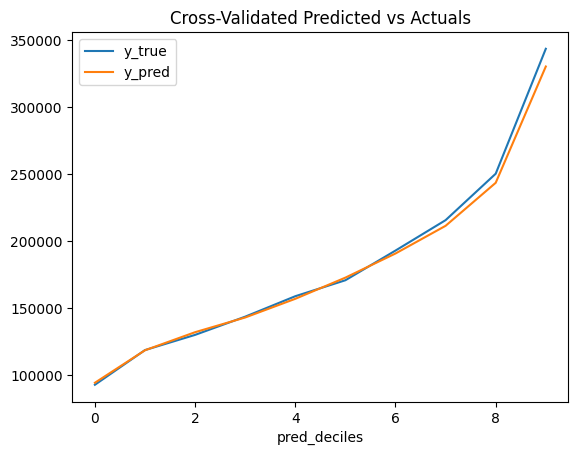

INFO:root:Cross-validation MAE: 15712.61
INFO:root:Cross-validation MAPE: 0.088201
INFO:root:Cross-validation R2: 0.8949 +/- 0.0236
INFO:root:Cross-validation MAPE: 0.088201
INFO:root:Cross-validation R2: 0.8949 +/- 0.0236


                     y_true         y_pred      counts  true_counts
pred_deciles                                                       
0              92503.846154   94005.960938  10998697.0     10822950
1             118391.752137  118260.093750  13836431.0     13851835
2             129734.401709  131737.250000  15413259.0     15178925
3             143324.508621  142712.281250  16554625.0     16625643
4             158580.564103  156651.156250  18328186.0     18553926
5             170499.615385  172446.921875  20176290.0     19948455
6             192645.232759  190458.375000  22093172.0     22346847
7             215336.683761  211108.390625  24699682.0     25194392
8             249979.410256  243194.703125  28453780.0     29247591
9             343189.376068  329957.843750  38605068.0     40153157


(15712.6064453125,
 0.08820146322250366,
 array([0.91782414, 0.86078698, 0.8755547 , 0.89924803, 0.92119192]))

In [111]:
evaluate_model(best_model, X_train, y_train)

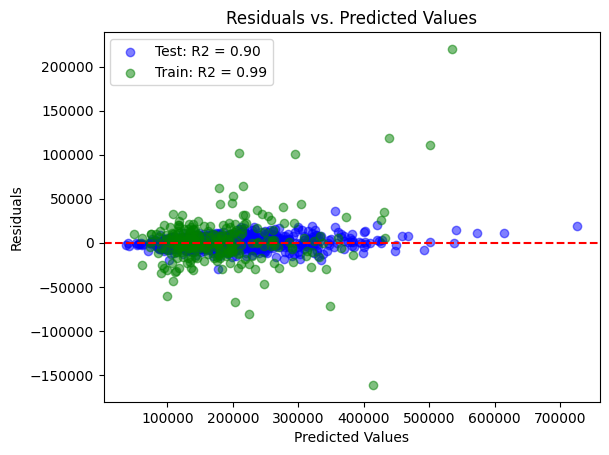

In [112]:
y_pred, test_residuals= plot_residuals(best_model, X_train, y_train, X_test, y_test)

/var/folders/7h/j94zr2xs6d149g6s96670f9c0000gn/T/ipykernel_5920/452156764.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result['importances'][sorted_idx[-15:]].T, vert=False, labels=display_labels)


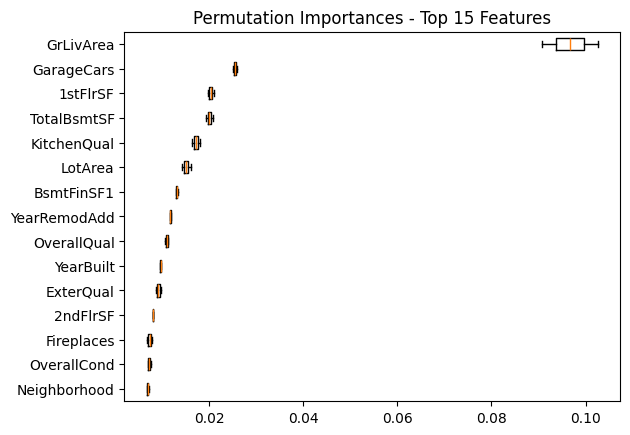

In [114]:
y_train_log = log_transform_target(y_train)

top_features, fig, result = get_permutation_importance_plot(best_model, X_train, y_train_log, n_repeats = 2, n_jobs= 1)

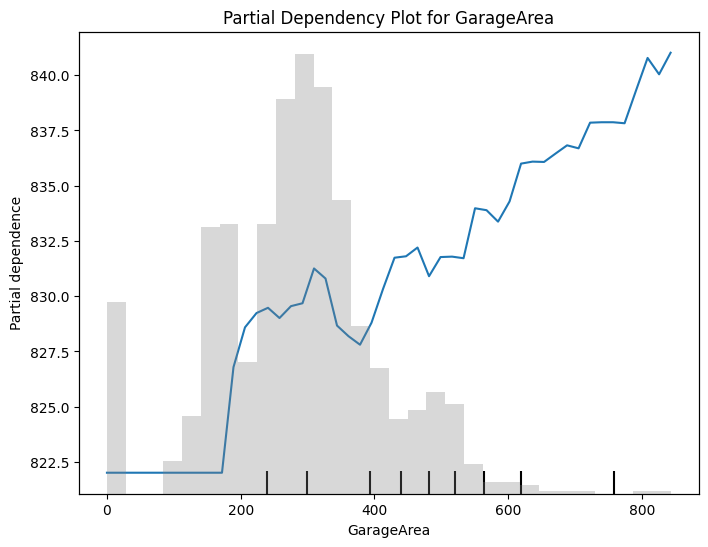

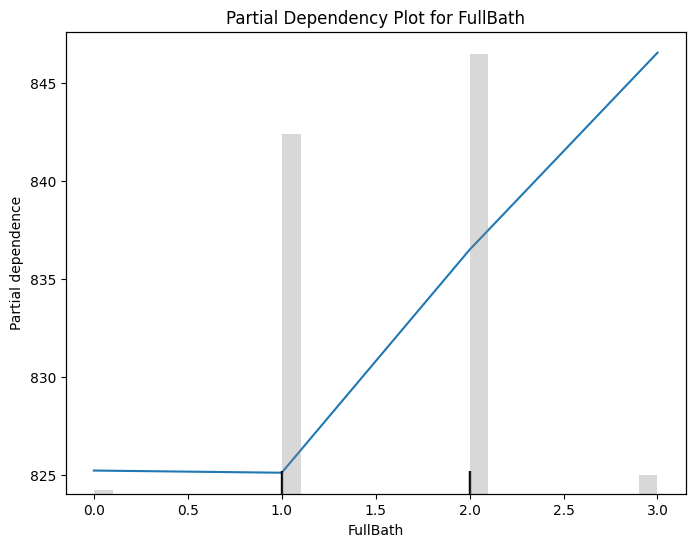

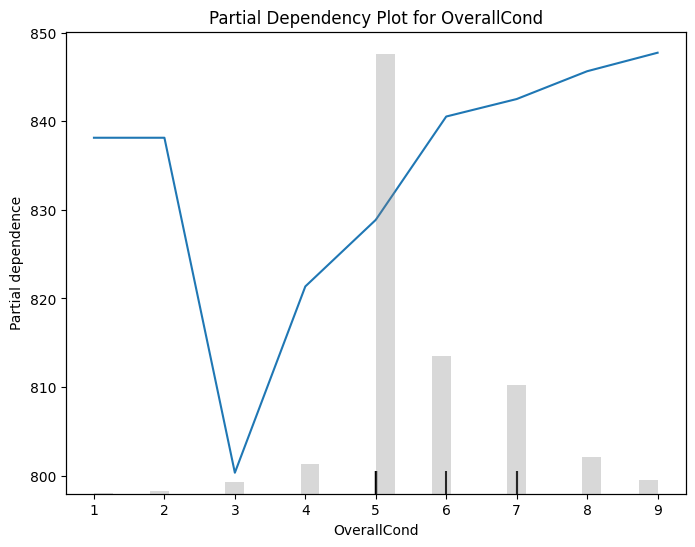

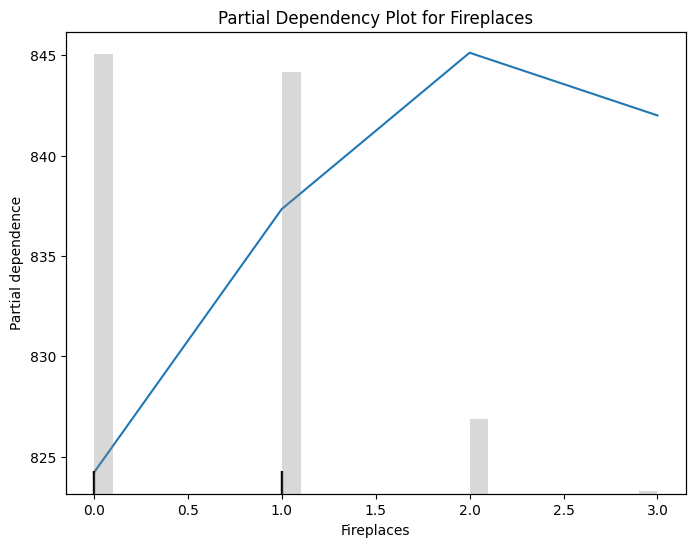

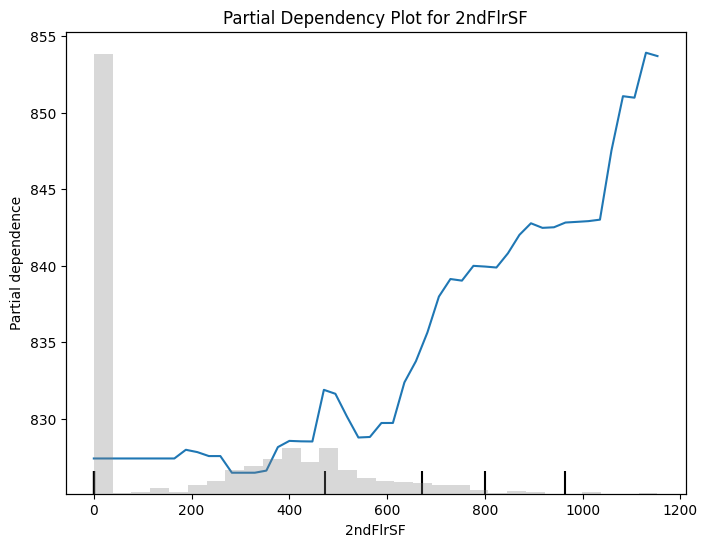

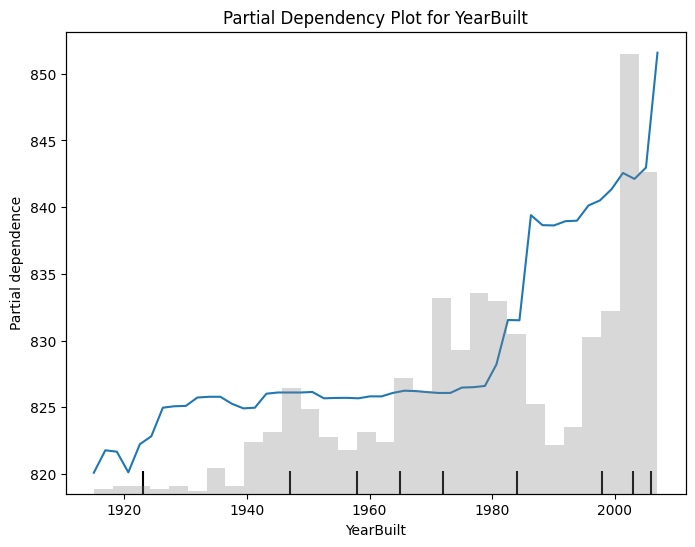

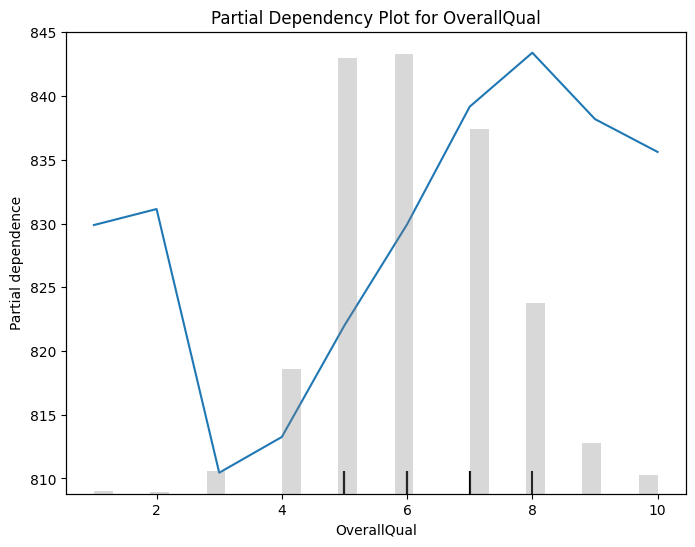

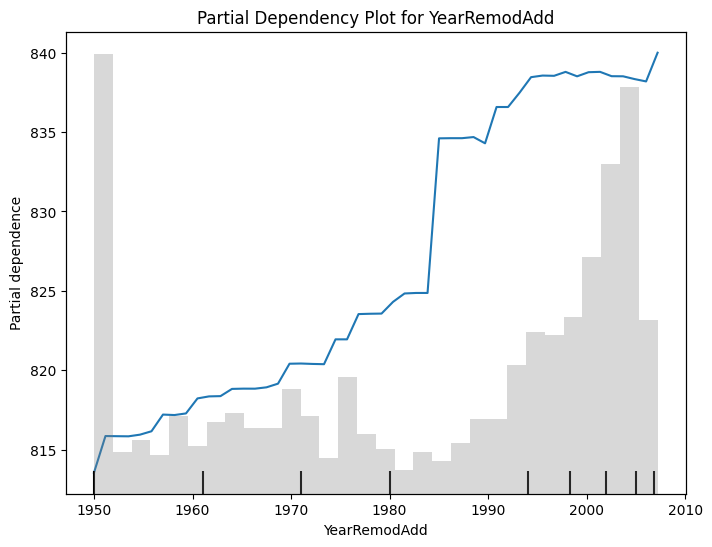

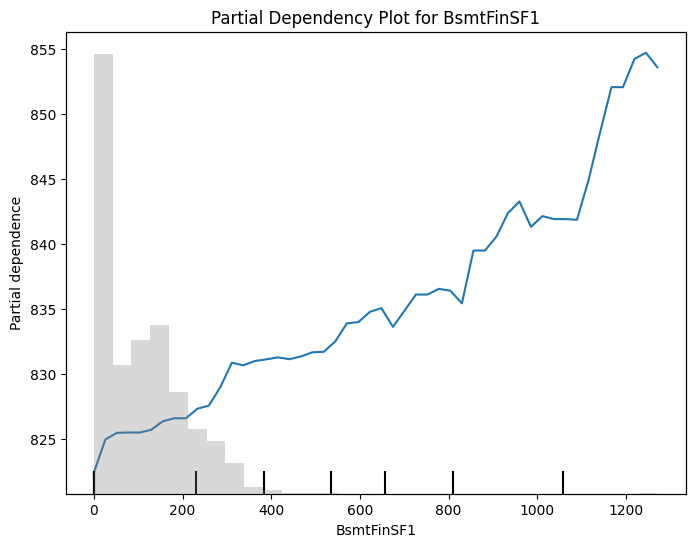

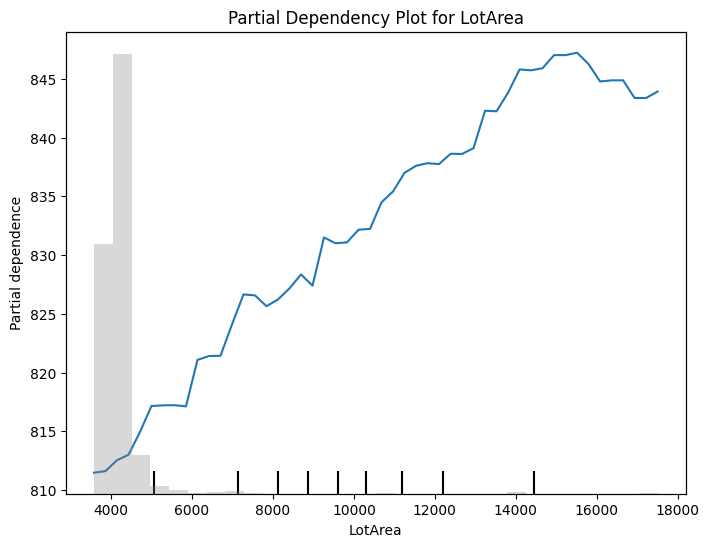

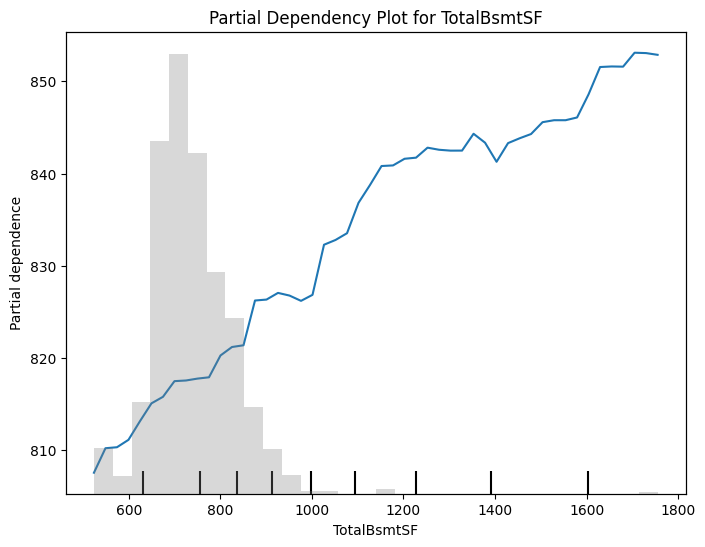

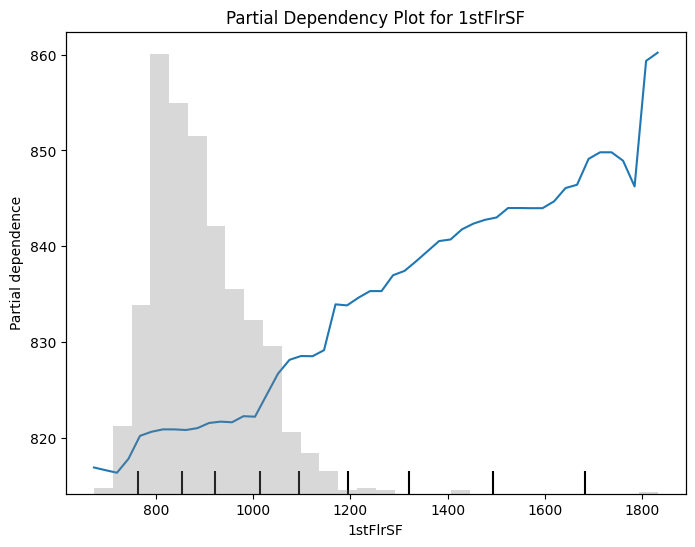

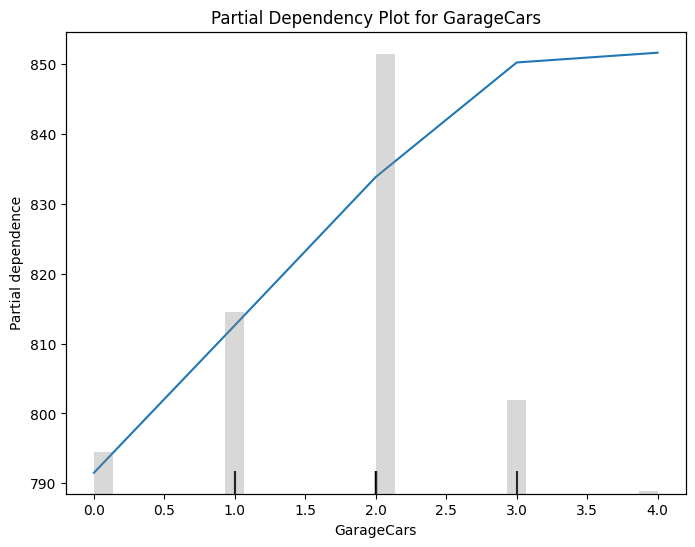

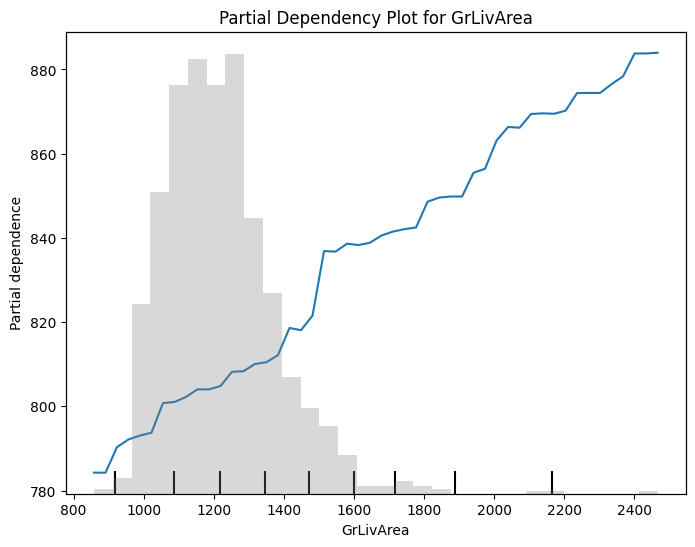

{'GarageArea': <Figure size 800x600 with 3 Axes>,
 'FullBath': <Figure size 800x600 with 3 Axes>,
 'OverallCond': <Figure size 800x600 with 3 Axes>,
 'Fireplaces': <Figure size 800x600 with 3 Axes>,
 '2ndFlrSF': <Figure size 800x600 with 3 Axes>,
 'YearBuilt': <Figure size 800x600 with 3 Axes>,
 'OverallQual': <Figure size 800x600 with 3 Axes>,
 'YearRemodAdd': <Figure size 800x600 with 3 Axes>,
 'BsmtFinSF1': <Figure size 800x600 with 3 Axes>,
 'LotArea': <Figure size 800x600 with 3 Axes>,
 'TotalBsmtSF': <Figure size 800x600 with 3 Axes>,
 '1stFlrSF': <Figure size 800x600 with 3 Axes>,
 'GarageCars': <Figure size 800x600 with 3 Axes>,
 'GrLivArea': <Figure size 800x600 with 3 Axes>}

In [115]:
plot_partial_dependency_with_histograms(best_model, X_train, top_features)